# China Main Historic Events
- https://www.bbc.com/news/world-asia-pacific-13017882
- https://policychangeindex.org/
- https://press-files.anu.edu.au/downloads/press/n4267/pdf/book.pdf

> ## Aggregate all MIIT and NDRC data together to make the Index.  

In [1]:
import re
import itertools
import pandas as pd
import os
import random
import time
from sqlalchemy import create_engine
import psycopg2
import io
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import math
from bubbly.bubbly import add_slider_steps
import plotly.offline as py
#import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff 
import warnings
warnings.filterwarnings('ignore')
from __future__ import absolute_import, division, print_function
# for word vec
import gensim
from gensim.models import Word2Vec as w2v
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import jieba.analyse
import codecs
import glob
import multiprocessing
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score

import pprint
import sklearn.manifold
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
from itertools import chain
from sklearn import preprocessing
from sqlalchemy import create_engine, text
import plotly.graph_objects as go
import seaborn as sns

data = pd.read_csv(r'C:\Users\ASUS\Desktop\Thesis\newMIIT_analysis.csv')
data.columns

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()


In [637]:
#data = pd.read_csv(r'C:\Users\ASUS\Desktop\Thesis\train_data_ipi.csv')
#data['date'] = pd.DatetimeIndex(data['date'])
# data['year_month'] = pd.to_datetime(data['date']).dt.to_period('M').astype(str)
# data_month = data.groupby(['year_month']).sum().reset_index(drop=False)
# data_month['avg'] = data_month.drop(['year_month'],axis=1).sum(axis=1)/8
data.tail()

,id,published_date,link,title,body,DocType,SubDocType,Type_industry,Prov,Pi_no,...,Price_manip,Supp_manip,Dem_manip,DimType,dimension_score,restrict_score,enable_score,force,Dim_cat,Ind_cat
11688,MIITinvestment_plans,2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展目标,1、“十一五”发展目标\r\n初步建立以企业为主体，市场为导向，应用为主线，“政产学研资”有...,None,None,软件,None,None,...,None,None,None,"规划, 规划, 目标",9.0001,9.0010,90.0019,8.910360e+02,planning,"Software, AI"
11689,MIITinvestment_plans,2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展思路,我国信息产业科技发展的总体思路是“一体双翼”，即围绕一个战略主体，选择两大发展方向，逐步实现...,None,None,None,None,None,...,None,None,None,"规划, 规划, 发展思路",8.0001,8.0009,168.0029,1.408048e+03,planning,None
11690,MIITinvestment_plans,2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——指导思想,我国信息产业的科技发展要以邓小平理论和“三个代表”重要思想为指导，以科学发展观统领全局，紧密...,None,None,None,None,None,...,None,None,None,"规划, 规划",9.0001,18.0011,306.0043,2.916081e+03,planning,None
11691,MIITinvestment_plans,2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展重点,根据信息产业技术发展趋势、战略需求和发展思路，提出未来5～15年以下15个领域发展的重点技术...,None,None,通信,None,None,...,None,None,None,"规划, 规划",13.0001,78.0019,117.0022,2.535073e+03,planning,Telecom
11692,MIITinvestment_plans,2006-05-08,http://www.miit.gov.cn/n1146295/n1146562/n1146...,2006━2020年国家信息化发展战略,中办发〔2006〕11号\r\n信息化是当今世界发展的大趋势，是推动经济社会变革的重要力量。...,None,None,None,None,None,...,价格,None,国际市场,规划,73.0001,3577.0122,30368.0489,2.477993e+06,planning,None


In [62]:

target = ['label']
predictors = data.columns.drop(['title','published_date','label'])

train_size = int(len(data) * 0.80)
train_df, test_df = data[0:train_size], data[train_size:len(data)]
train, test = train_test_split(df, test_size=0.2)


clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

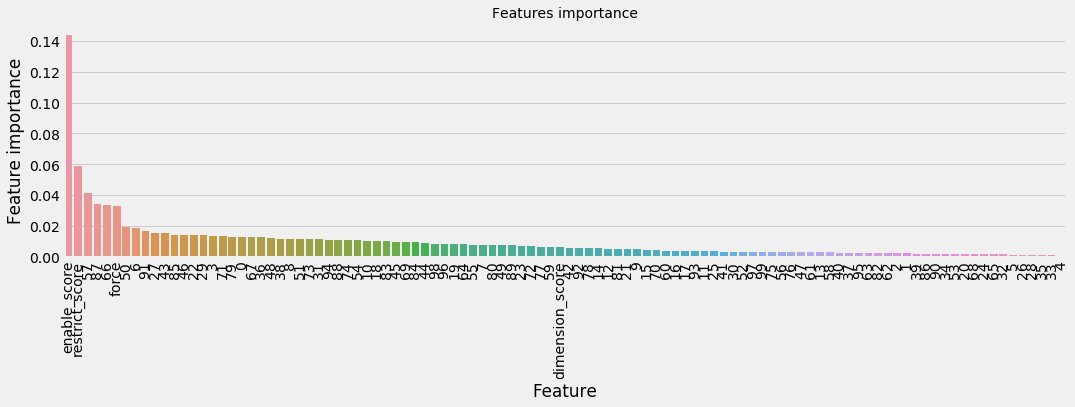

In [63]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

confusion matrix:
[[16  8]
 [ 0 79]]
classification report:
             precision    recall  f1-score   support

          0       1.00      0.67      0.80        24
          1       0.91      1.00      0.95        79

avg / total       0.93      0.92      0.92       103

Normalized confusion matrix
[[0.66666667 0.33333333]
 [0.         1.        ]]


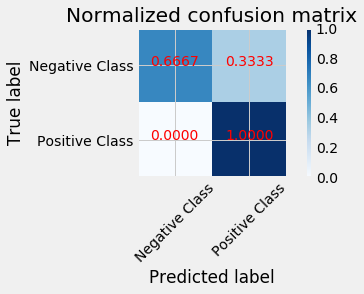

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")
                 #color="red" if cm[i, j] > thresh else "black")
    #plt.set_tight_layout(True)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
preds = clf.predict(test_df[predictors])
cm = confusion_matrix(test_df[target].values, preds)
print('confusion matrix:')
print(cm)
#print('\n')
print('classification report:')
print(classification_report(test_df[target].values, preds))
plot_confusion_matrix(cm, classes=['Negative Class', 'Positive Class'], normalize=True, title='Normalized confusion matrix')

hide_toggle()

In [70]:
from sklearn.model_selection import KFold, StratifiedKFold
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

params2 = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

hide_toggle()

In [2]:
import lightgbm as lgb
oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))
scores = []
feature_importance = pd.DataFrame()
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    model = lgb.train(params,train_data,num_boost_round=20000,
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

NameError: name 'X' is not defined

In [73]:
hide_toggle()

# import plotly.graph_objects as go
# trace = dict(
#     x= data_month["year_month"],
#     y= data_month['avg'],
#     name='average',
#     hoverinfo='x+y',
#     mode='lines',
#     line=dict(width=0.5),
#     stackgroup='one'
# )

# data = [trace]

# layout = go.Layout(
#     title=go.layout.Title(
#         text='Industrial Policy Influence Index of NDRC',
#         xref='paper',
#         font=dict( size=22)
#     ))
# figure = go.Figure(data=data, layout=layout)
# fig = go.FigureWidget(figure)
# fig.update_layout(xaxis_rangeslider_visible=True,showlegend=False,
#                   margin=dict(l=20, r=20, t=50, b=20))

# fig.add_trace(go.Scatter(
#     x=['2005-10','2005-10'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2005 Oct - Reform Slowdown: Improving Social Welfare."],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2006-05','2006-05'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2006 May - Work on the structure of the Three Gorges Dam"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2008-11','2008-11'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2008 Nov - Stimulus Package: mitigating against the Financial Crisis"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2013-09','2013-09'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2013 Sep - Renew Reform Programs: revisiting market reforms"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2015-03','2015-03'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2015 March - China Internet Plus Initiative"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2015-05','2015-05'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2015 May - Made in China 2025 Initiative"],
#     textposition="top center"
# ))

# fig.add_trace(go.Scatter(
#     x=['2015-04','2015-04'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2015 Apr - Water Pollution Prevention and Control Action Plan"],
#     textposition="top center"
# ))

# fig.add_trace(go.Scatter(
#     x=['2015-11','2015-11'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2015 Nov - Supply-side Structural Reform: State lead to eliminate excess capacity"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2018-12','2018-12'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2018 Mar - NDRC announces collaboration with Foreign Automotive Partners"],
#     textposition="top center"
# ))
# fig.add_trace(go.Scatter(
#     x=['2019-03','2019-03'],
#     y=[0, 1],
#     mode="lines+markers+text",
#     hovertext=[" ","2019 Mar - NDRC announces Major Foreign Investment projects in Energy Sector"],
#     textposition="top center"
# ))

hide_toggle()

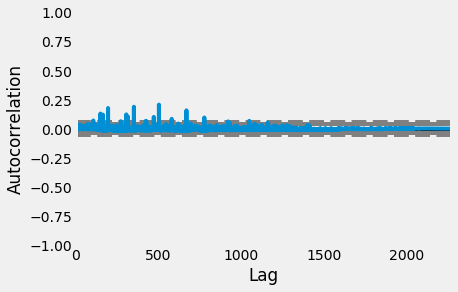

In [27]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') 
autocorrelation_plot(data['POL_ANNCOUNCE'])

# breakdown of regulation per channel (opinion, policy, etc.) on MDRC percentage
- https://plot.ly/python/line-charts/

In [31]:
import statsmodels.api as sm
import numpy as np

X = data[['POL_ANNCOUNCE', 'POL_INTERPRETATION_DOC', 'POL_decree',
       'POL_normalized_doc', 'POL_notification_doc', 'POL_others',
       'POL_planning', 'POL_explain_doc', 'REF_comprehensive_status',
       'REF_policy_plan', 'REF_sustainable_situation',
       'REF_major_projects', 'REF_comprehensive_industrial_status',
       'REF_science_center', 'REF_sustainable_ecology', 'REF_water_energy',
       'REF_Env_protection', 'REF_industrial_work', 'REF_service_work',
       'REF_hightech_work', 'REF_dev_dynamics']]

y = data["REF_policy_release"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     REF_policy_release   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.510
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           0.000233
Time:                        19:14:05   Log-Likelihood:                 3633.2
No. Observations:                2269   AIC:                            -7226.
Df Residuals:                    2249   BIC:                            -7112.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
POL_ANNCOUNCE                           0.0348      0.027      1.277      0.202      -0.019       0.088
POL_INTERPRETATION_DOC                  0.0334      0.013      2.506      0.012       0.007       0.060
POL_decree                              0.0400      0.035      1.137      0.256      -0.029       0.109
POL_normalized_doc                     -0.0106      0.035     -0.306      0.760      -0.079       0.058
POL_notification_doc                    0.0161      0.025      0.639      0.523      -0.033       0.066
POL_others                              0.0320      0.026      1.243      0.214      -0.018       0.082
POL_planning                            0.0199      0.027      0.731      0.465      -0.034       0.073
POL_explain_doc                         0.0456      0.045      1.016      0.310      -0.042       0.134
REF_comprehensive_status               -0.0021      0.012     -0.180      0.857      -0.025       0.021
REF_policy_plan                         0.0361      0.043      0.844      0.399      -0.048       0.120
REF_sustainable_situation               0.0069      0.018      0.391      0.696      -0.028       0.042
REF_major_projects                      0.0410      0.037      1.104      0.270      -0.032       0.114
REF_comprehensive_industrial_status    -0.0021      0.012     -0.180      0.857      -0.025       0.021
REF_science_center                     -0.0172      0.050     -0.343      0.732      -0.116       0.081
REF_sustainable_ecology                -0.0094      0.027     -0.344      0.731      -0.063       0.044
REF_water_energy                        0.0309      0.023      1.367      0.172      -0.013       0.075
REF_Env_protection                      0.0536      0.036      1.494      0.135      -0.017       0.124
REF_industrial_work                     0.0447      0.023      1.909      0.056      -0.001       0.091
REF_service_work                        0.0316      0.019      1.684      0.092      -0.005       0.068
REF_hightech_work                       0.0852      0.028      3.052      0.002       0.030       0.140
REF_dev_dynamics                       -0.0055      0.029     -0.187      0.852      -0.063       0.052
==============================================================================
Omnibus:                     3762.825   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2324284.291
Skew:                          10.983   Prob(JB):                         0.00
Kurtosis:                     158.249   Cond. No.                     7.07e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The sm

# Analysis of Variables: restricting, enabling relationships.

In [5]:
# load in data
data = pd.read_csv(r'C:\Users\ASUS\Desktop\Thesis\newMIIT_analysis.csv')
data.columns

Index(['Unnamed: 0', 'id', 'published_date', 'link', 'title', 'body',
       'DocType', 'SubDocType', 'Type_industry', 'Prov', 'Pi_no', 'Hao_no',
       'Dept', 'Audience', 'Raw_materials', 'Tax', 'Price_manip', 'Supp_manip',
       'Dem_manip', 'DimType', 'dimension_score', 'restrict_score',
       'enable_score', 'force', 'Dim_cat', 'Ind_cat'],
      dtype='object')

# Research question: how is Chinese market regulators interact with economic tools?
Summarization of how the chinese regulator interacts with the economic tools can be described in three different hypotheses:
> ## 1) first, the government allocates resources directly and differently;
across sectors, dimensions, markets, how does the resources flow work?
How to measure resources (#subsidies, #leading, etc.)
Enable score comparison across dimensions, industries, sectors. 

> ## 2) second, selective and restrictive examination and approval on market access is unequal to all localities; (implies different means across local governments?)
metrics : industries differences in score
Restrictive score comparison between


# DocType's impact on the Enablility, Restrictiveness, and Influence

In [6]:
# data = data[data.DocType != "公报"]
# data = data[data.DocType != "命令"]
# data = data[data.DocType != "议案"]

import plotly.express as px
fig = px.box(data, x="DocType", y="force",color="DocType")
fig.show()

In [226]:
fig = px.box(data, x="DocType", y="dimension_score",color="DocType")
fig.show()

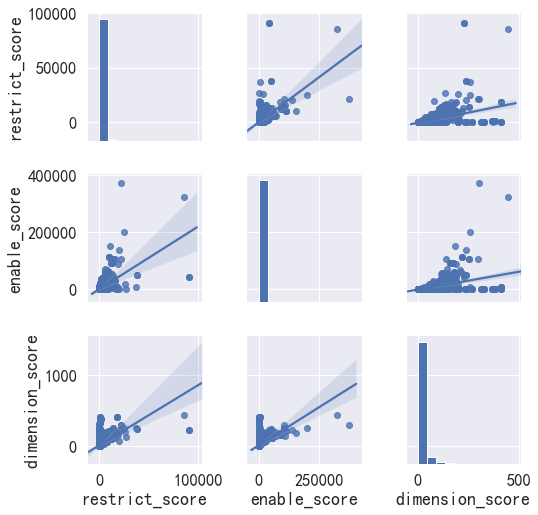

In [642]:
import seaborn as sns
sns.pairplot(data, vars=['restrict_score', 'enable_score', 'dimension_score'],
                  kind='reg') 

## Observations
- Strongest: Letters，通告，意见， contain the strongest Dimension-restrictive relationship
- Weakest: 决定，通报，批复

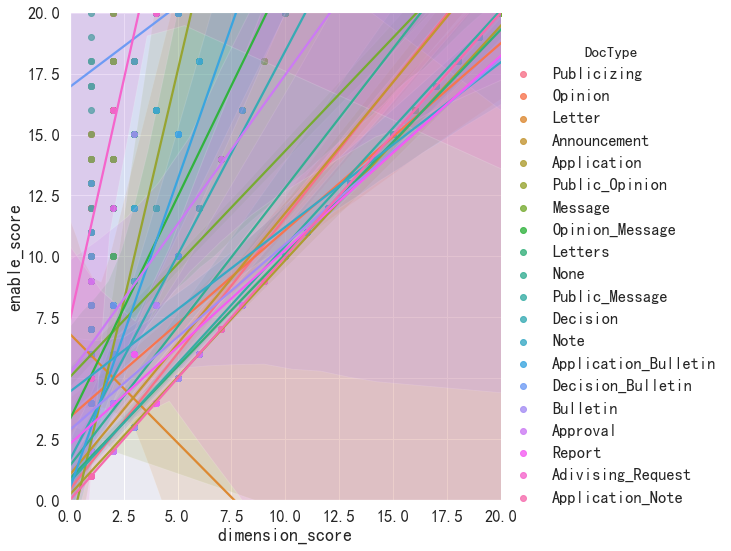

In [644]:
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

g= sns.lmplot(size = 8, x= 'dimension_score', y= 'enable_score', hue= "DocType",
              #palette=["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"],
              data= data[(data['dimension_score']<100) & (data['enable_score']<30)])
g.set(ylim=(0,20),xlim=(0,20))
              

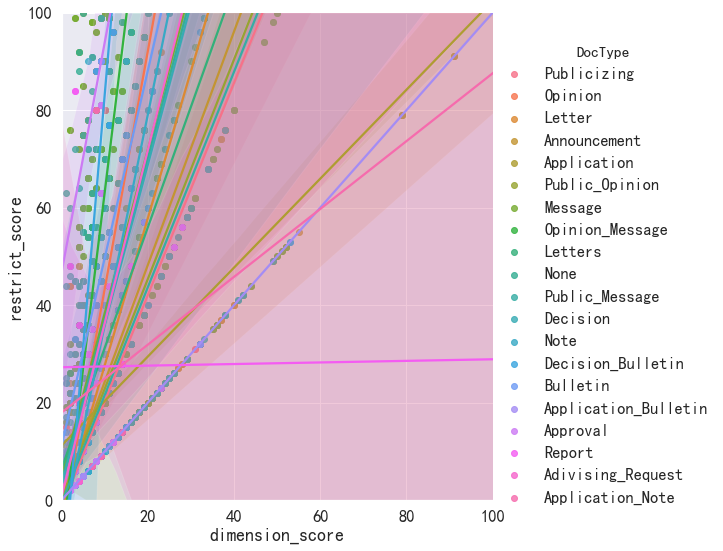

In [645]:
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

g= sns.lmplot(size = 8, x= 'dimension_score', y= 'restrict_score', hue= "DocType",
              data= data[(data['dimension_score']<100) & (data['restrict_score']<200)])
g.set(ylim=(0,100),xlim=(0,100))

- Strongest: 报告， letter, 通报
- weak: 通告，批复，公告

In [618]:
NEW_DATA = pd.read_csv(r'C:\Users\ASUS\Desktop\Thesis\MIIT_analysis2.csv')


# Making replacing values in levels easier?

In [619]:
def get_common_words(doc_tokens, parameter):
    match = lambda a, b: [ b.index(x)+1 if x in b else None for x in a ]
    mylist = match(doc_tokens, parameter)
    ind = [e for e in mylist if e != None]
    if len(ind) is not 0:
        return [parameter[i-1] for i in ind]
    else:
        return [''] # output only the key words or space

True_Ind = []
for i in NEW_DATA.Type_industry.value_counts().index:
    True_Ind.append(i) 
    
testing = get_common_words(True_Ind,Software_AI)

    
test2=[]    
for i in testing:
    data['Ind_cat'] = data.Type_industry.replace({
    ''+i+'':'Software_AI'})
                    
del data['Ind_cat']

In [602]:
#MIIT_TECH_ELEK = [
    # EV & Energy & car:
EV_Energy_car =[   "新能源汽车","电动汽车","道路机动车","锂离子电池","汽车","新能源","铅蓄电池","光伏","锂离子电池","电动自行车"
    "车联网","智能网联汽车","车辆","电池","能源", "风电","光伏发电","石油","摩托车"]
    # Electronic hardware Equipment:
Electronic_hardware_equipment=[ "卫星移动通信","卫星无线电频率","卫星","电器电子","电路产业","基础元器件","元器件","电子材料","关键元器件",
    "残余应力超声","机械","纤维光学","电工电子"]
    # Software AI
Software_AI=["人工智能", "软件产业","软件","无人机制造","智能安全"]
    # Telecom
Telecom = [  "电信业务","集成电路","机器类通信","电信","通信","5G","移动通信", "电信网码号","无线电干扰","频段宽带",
    "信息和通信"
Internet_Commerce_IOT_Manufacturing = [
    "互联网APP","物联网集成","物联网","互联网","电子商务"]
    # Machinery Manufacturing
Machinery_Manufacturing= [  "制造业","制造","生产企业","基础制造装备","高档数控机床","农机","智能制造"]
    # Green Recycle
Green_Recycling_Industry= [ "废塑料综合","绿色","绿色供应链","循环经济","废轮胎综合","胎综合","能耗限额","废旧动力蓄电池",
    "低碳工业","废钢铁","节能机电设备"]
    # Others
 Others =[  "食品","化工" ,"航空","船舶","挂车","房地产","娱乐和文娱","教育","物流"]
    # Military Defense 
Shipping_Aviation_Military_Defense=  [  "军民","国防","国防科技","航空","船舶"]
                  # Recyling ind
                 ]

RAW_CHEM_MATERIALS = ["农药","农药产品","聚氯化铝","包装","铜冶炼","砂石","萤石","印染","化学品","烟花爆竹",
                     "冶金","建材","石化","轨道资源","腐植酸肥料增","搪玻璃","废钢铁","玻璃纤维","水泥",
                      "铸造用生铁", "钢铁", "铸造用生铁","建材","铁合金","炸药","轮胎翻新","黄金矿","爆炸物",
                     "多晶硅","磁性元件","铁氧体","爆炸物","三聚氰胺","化学","建筑卫生陶瓷","石油"]

# NEED TO COMPARE CROSS INDUSTRIES.

In [2]:
data = data

data['Audience'] = data.Audience.replace({
    '企业':'Enterprise',         
    '自治区':'Autonomous_Region',        
    '公司':'Enterprise',          
    '市场':'Market',          
    '地区':'District',          
    '各省':'Province',           
    '公司, 企业':'Enterprise',      
    '各直属机构':'Direct_Institutions',       
    '企业, 企业':'Enterprise',       
    '企业, 市场':'Market',        
    '直辖市人民政府':'Municipal',       
    '企业, 公司':'Enterprise',        
    '民政':'Direct_Institutions',            
    '市场, 地区':'District'        
})

data['SubDocType'] = data.SubDocType.replace({
    '名单':'Roster',                
    '规定':'Regulation',                
    '目录':'Directory',
    '发布':'Publication',
    '条件':'Conditions',
    '数据':'Data',
    '评价':'Evaluation',
    '发布, 名单':'Roster_Publication',             
    '名单, 发布':'Roster_Publication',              
    '发布, 目录':'Directory',              
    '法律':'Law',
    '评价, 名单':'Evaluation_Roster',              
    '税收政策':'Tax_Policy',                
    '条件, 条件':'Conditions',              
    '目录, 发布':'Directory',              
    '条件, 名单':'Conditional_Roster',               
    '评价结果':'Evaluation',                 
    '行政法规':'Law',                 
    '目录, 名单':'Roster',               
    '税收政策, 目录':'Tax_Policy',            
    '名单, 名单':'Roster',               
    '部门规章':'Rules',                 
    '发布, 条件':'Conditions',               
    '税收政策, 名单':'Tax_Policy',             
    '评价, 评价':'Evaluation',               
    '规定, 发布':'Regulation',               
    '发布, 规定':'Regulation',               
    '目录, 目录':'Directory',               
    '法律, 规定':'Regulation',               
    '数据, 发布':'Data',               
    '发布, 名单, 名单':'Roster',           
    '条件, 评价':'Evaluation',              
    '发布, 评价':'Evaluation',               
    '发布, 发布, 规定':'Regulation',           
    '演讲':'Speech',                   
    '发布, 税收政策':'Tax_Policy',             
    '条件, 条件, 发布':'Conditions',           
    '司法解释':'Interpretation',                 
    '条件, 名单, 条件, 名单':'Roster'       
})

data['DocType'] = data.DocType.replace({
    '通知':'Message',
    '公告':'Announcement',
    '公示':'Publicizing',
    '意见':'Opinion',             
    '函':'Letters',             
    '通告':'Note',
    '批复':'Approval',
    '申请':'Application',
    '公告, 公示':'Publicizing',         
    '通报':'Bulletin',             
    '公告, 通知':'Message',
    '决定':'Decision',
    '公示, 通知':'Public_Message',
    '意见, 通知':'Opinion_Message',
    '公示, 公告':'Announcement', 
    '报告':'Report',
    '决定, 通报':'Decision_Bulletin',
    '申请, 通报':'Application_Bulletin',
    '公告, 公告, 通知':'Message',
    '公告, 公告':'Announcement', 
    '请示':'Adivising_Request',
    '申请, 通告':'Application_Note',
    '意见, 函':'Letter',
    '公告, 意见':'Public_Opinion',
    '决定, 公告':'Decision',           
    '意见, 意见':'Opinion',
    '通知, 通知':'Message',
    '函, 函':'Letters',
    '申请, 通知':'Application_Note',           
    '申请, 批复':'Approval',
    '通报, 通知':'Message',
    '报告, 通知':'Message',
    '申请, 公示':'Application',
    '意见, 公告':'Opinion',
    '公告, 意见, 函':'Letters',
    '函, 公告':'Announcement',
    '通知, 意见':'Opinion',
    '通报, 批复':'Approval',
    '决定, 意见, 通知':'Message',
    '公告, 意见, 公示':'Publicizing',
    '申请, 意见':'Opinion',
    '通报, 函':'Letters',
    '公告, 申请, 通知':'Message',
    '意见, 意见, 函':'Opinion',
    '决定, 通知':'Decision_Bulletin',           
    '报告, 意见':'Opinion',           
    '命令':'Order',
    '公告, 公告, 公示':'Announcement',
    '申请, 决定, 公告':'Decision',
    '公示, 公示':'Publicizing',
    '意见, 公示':'Public_Opinion',           
    '议案':'Bill',               
    '通告, 意见, 公示':'Public_Opinion',       
    '通告, 意见':'Public_Opinion'  })         

data['Dim_cat'] = data.DimType.replace({
        '标准':'regulations',
        '规划':'planning',
        '证书':'regulations',
        '计划':'planning',
        '许可证':'regulations',
        '目标':'planning',                 
        '产品质量':'regulations',
        '战略':'planning',  
        '风险':'planning',
        '生产许可':'regulations',
        '关键技术':'favoring',
        '思路':'planning',
        '营业执照':'regulations',
        '食品安全':'regulations',
        '质量控制':'regulations',
        '诚信体系':'regulations',
        '企业诚信体系':'regulations', 
        '产品标准':'regulations', 
        '保障机制':'regulations',
        '国有':'ownership',
        '市场调节价':'regulations',
        '制售假冒伪劣':'regulations',
        '国有企业':'ownership',
        '产品安全':'regulations',
        '标准, 计划':'planning',
        '目标, 计划':'planning',
        '质量安全管理':'regulations',
        '规划, 规划':'planning',
        '产品质量法':'regulations', 
        '质量控制, 产品质量':'regulations',
        '出口信用保险':'regulations',
        '发展思路':'planning',
        '质量认证':'regulations',
        '关键元器件':'favoring',
        '重点项目建设':'favoring',
        '许可证, 证书, 证书':'regulations',
        '不合格产品':'regulations',
        '重点装备':'favoring',
        '企业诚信体系, 企业诚信体系':'regulations',
        '生产许可, 生产许可':'regulations',
        '计划, 计划, 战略':'planning',
        '标准, 标准':'regulations',
        '计划, 计划':'planning',
        '检测装备':'regulations',
        '战略, 战略':'planning',
        '行业准入门槛':'regulations',
        '非法进出口':'regulations',
        '产品质量, 规划':'regulations',
        '战略, 规划':'planning',
        '规划, 规划, 发展思路':'planning',
        '风险监测':'regulations',
        '规划, 规划, 目标':'planning'})

data['Ind_cat'] = data.Type_industry.replace({
    '通信': 'Telecom',            
    '生产企业':'Machinery, Manufacturing',                   
    '电信':'Telecom',                     
    '车辆, 生产企业':'EV,Energy,Car' ,              
    '软件':'Software, AI'    ,                 
    '制造':'Machinery, Manufacturing'  ,                   
    '互联网':'Internet Commerce, IOT Manufacturing'  ,                  
    '新能源汽车':'EV,Energy,Car'    ,              
    '绿色':'Green Recycling Industry'  ,                   
    '制造业':'Machinery, Manufacturing' ,                   
    '移动通信':'Telecom'       ,            
    '电信业务':'Telecom',                  
    '能源':'EV,Energy,Car'     ,                
    '车辆, 生产企业, 车辆, 生产企业':'EV,Energy,Car' ,     
    '船舶':'Shipping, Aviation, Military Defense'  ,                    
    '教育':'R&D, Training'              ,        
    '智能制造':'Machinery, Manufacturing'  ,                  
    '车辆':'EV,Energy,Car'           ,           
    '食品':'Other'                ,      
    '机械':'Electronics,Hardware Equipment'     ,                 
    '摩托车, 生产企业':'EV,Energy,Car'        ,       
    '道路机动车, 生产企业, 车辆':'EV,Energy,Car'     ,    
    '军民':'Shipping, Aviation, Military Defense'    ,                 
    '集成电路':'Electronics,Hardware Equipment'   ,                 
    '循环经济':'Green Recycling Industry'   ,                 
    '道路机动车, 生产企业':'EV,Energy,Car'  ,           
    '铅蓄电池':'EV,Energy,Car'   ,                
    '电子商务':'Internet Commerce, IOT Manufacturing' ,                   
    '物联网':'Internet Commerce, IOT Manufacturing'  ,                  
    '航空':'Shipping, Aviation, Military Defense',
    '通信, 移动通信':'Telecom',
    '道路机动车, 生产企业, 车辆, 生产企业':'EV,Energy,Car',
    '卫星':'Telecom',
    '节能机电设备':'Green Recycling Industry',
    '摩托车':'EV,Energy,Car', 
    '绿色, 制造':'Machinery, Manufacturing',
    '通信, 通信':'Telecom', 
    '废钢铁':'Green Recycling Industry', 
    '石油':'EV,Energy,Car', 
    '车辆, 新能源汽车':'EV,Energy,Car',
    '光伏, 制造':'EV,Energy,Car',
    '锂离子电池':'EV,Energy,Car', 
    '光伏':'EV,Energy,Car', 
    '制造业, 互联网':'Internet Commerce, IOT Manufacturing', 
    '电动汽车':'EV,Energy,Car', 
    '能耗限额':'Green Recycling Industry', 
    '农机':'Machinery, Manufacturing', 
    '车辆, 生产企业, 生产企业':'EV,Energy,Car',
    '人工智能':'Software, AI', 
    '废轮胎综合':'Green Recycling Industry', 
    '国防':'Shipping, Aviation, Military Defense', 
    '国防科技':'Shipping, Aviation, Military Defense', 
    '高档数控机床, 基础制造装备':'Machinery, Manufacturing', 
    '电信, 互联网':'Telecom',
    '软件, 集成电路':'Software, AI',
    '电动自行车':'EV,Energy,Car', 
    '电信业务, 电信, 电信':'Telecom', 
    '生产企业, 生产企业':'Machinery, Manufacturing', 
    '车辆, 生产企业, 摩托车':'EV,Energy,Car', 
    '互联网, 互联网':'Internet Commerce, IOT Manufacturing',
    '物流':'Other', 
    '元器件':'Electronics,Hardware Equipment', 
    '车联网':'EV,Energy,Car', 
    '互联网APP':'Internet Commerce, IOT Manufacturing', 
    '低碳工业':'Green Recycling Industry', 
    '新能源汽车, 生产企业':'EV,Energy,Car', 
    '废塑料综合':'Green Recycling Industry',
    '车联网, 智能网联汽车':'EV,Energy,Car', 
    '移动通信, 移动通信':'Telecom', 
    '道路机动车':'EV,Energy,Car', 
    '电子商务, 移动通信':'Internet Commerce, IOT Manufacturing', 
    '移动通信, 通信':'Telecom',
    '铅蓄电池, 铅蓄电池':'EV,Energy,Car', 
    '无线电干扰':'Telecom', 
    '新能源汽车, 车辆':'EV,Energy,Car', 
    '电信, 电信业务':'Telecom', 
    '电池':'EV,Energy,Car', 
    '机械, 船舶':'Shipping, Aviation, Military Defense',
    '摩托车, 制造':'EV,Energy,Car',
    '挂车':'Other', 
    '能源, 新能源汽车':'EV,Energy,Car', 
    '物联网集成':'Internet Commerce, IOT Manufacturing', 
    '制造业, 制造业':'Machinery, Manufacturing', 
    '机械, 航空, 船舶':'Shipping, Aviation, Military Defense',
    '新能源汽车, 新能源汽车':'EV,Energy,Car', 
    '卫星移动通信':'Telecom', 
    '电子材料':'Electronics,Hardware Equipment', '教育, 卫星':'R&D, Training', 
    '国防科技, 国防':'Shipping, Aviation, Military Defense',
    '新能源汽车, 废旧动力蓄电池, 新能源汽车, 废旧动力蓄电池':'Green Recycling Industry',
    '5G':'Telecom', '电信, 通信':'Telecom', '软件产业':'Software, AI',
    '道路机动车, 生产企业, 道路机动车':'EV,Energy,Car', 
    '通信, 通信, 通信':'Telecom', 
    '船舶, 船舶, 制造':'Shipping, Aviation, Military Defense', 
    '移动通信, 电信':'Telecom', 
    '绿色供应链':'Green Recycling Industry',
    '制造业, 互联网, 互联网':'Internet Commerce, IOT Manufacturing', 
    '石油, 生产企业':'EV,Energy,Car', 
    '电动汽车, 电动汽车':'EV,Energy,Car', 
    '卫星无线电频率':'Telecom', '卫星, 生产企业':"Telecom",
    '集成电路, 集成电路':'Electronics,Hardware Equipment', 
    '电信, 移动通信':'Telecom', 
    '智能网联汽车':'EV,Energy,Car', 
    '风电':'EV,Energy,Car', 
    '频段宽带':'Telecom', '绿色, 绿色':'Green Recycling Industry', 
    '纤维光学':'Electronics,Hardware Equipment',
    '循环经济, 循环经济':'Green Recycling Industry', 
    '制造, 互联网':'Internet Commerce, IOT Manufacturing', 
    '电动自行车, 锂离子电池':'EV,Energy,Car', 
    '智能安全':'Software, AI', '废塑料综合, 废塑料综合':'Green Recycling Industry',
    '关键元器件':'Electronics,Hardware Equipment', 
    '石油, 能源':'EV,Energy,Car', 
    '食品, 食品':'Other', '绿色, 软件':'Software, AI', '新能源汽车, 废旧动力蓄电池':'EV,Energy,Car', 
    '电信业务, 电信业务':'Telecom',
    '锂离子电池, 锂离子电池':'EV,Energy,Car', 
    '集成电路, 军民':'Shipping, Aviation, Military Defense', 
    '卫星, 通信, 移动通信, 通信':'Telecom', '移动通信, 通信, 通信':'Telecom',
    '残余应力超声':'Electronics,Hardware Equipment', '物联网, 电动自行车, 通信':'EV,Energy,Car', 
    '软件, 软件':'Software, AI', '船舶, 船舶, 生产企业':'Shipping, Aviation, Military Defense',
    '高档数控机床, 基础制造装备, 软件':'Electronics,Hardware Equipment', 
    '机械, 通信':'Telecom', '废钢铁, 废钢铁':'Green Recycling Industry', 
    '航空, 船舶':'Shipping, Aviation, Military Defense', 
    '互联网, 通信':'Telecom', '通信, 电信业务':'Telecom', 
    '机械, 航空':'Shipping, Aviation, Military Defense', '软件产业, 软件产业':'Software, AI', 
    '通信, 电信':'Telecom', '船舶, 船舶':'Shipping, Aviation, Military Defense', 
    '移动通信, 5G':'Telecom', '电动汽车, 集成电路':'EV,Energy,Car', '车联网, 智能网联汽车, 通信':'EV,Energy,Car',
    '制造, 制造':'Machinery, Manufacturing', 
    '机器类通信':'Telecom', '互联网, 互联网, 通信':'Telecom',
    '废塑料综合, 废轮胎综合':'Green Recycling Industry', 
    '通信, 5G, 通信':'Telecom', 
    '摩托车, 摩托车':'EV,Energy,Car', 
    '通信, 电信, 互联网, 通信':"Telecom",
    '电动自行车, 电动自行车':'EV,Energy,Car',                               
    '移动通信, 卫星':'Telecom'  ,                                 
    '基础元器件, 电子材料, 元器件':'Electronics,Hardware Equipment',                           
    '5G, 通信, 通信':'Telecom'  ,                               
    '能源, 绿色':'EV,Energy,Car'  ,                                   
    '通信, 物联网, 电动自行车':'EV,Energy,Car' ,                            
    '基础元器件':'Electronics,Hardware Equipment',                                     
    '光伏, 制造, 光伏, 制造':'EV,Energy,Car'
})
hide_toggle()


In [15]:
data.to_csv(r'C:\Users\ASUS\Desktop\Thesis\newMIIT_analysis.csv')

In [14]:
data.Ind_cat.value_counts()

None                                    6097
Telecom                                 1729
EV,Energy,Car                           1324
Machinery, Manufacturing                1143
Green Recycling Industry                 341
Internet Commerce, IOT Manufacturing     306
Software, AI                             263
Shipping, Aviation, Military Defense     216
Electronics,Hardware Equipment           125
R&D, Training                             76
Other                                     73
Name: Ind_cat, dtype: int64

In [497]:
COUNTS_group = data.groupby(['ind']).count().force.reset_index(drop=False)
COUNTS_group.sort_values('force', ascending=False).reset_index(drop=True)

,ind,force
0,None,8752
1,汽车,1006
2,安全,543
3,制造业,487
4,能源,243
5,环境,187
6,化工,123
7,法律,65
8,专业服务,64
9,教育,53


In [462]:
fig.show()

Telecom_std : 1001.8776956968728
EV,Energy,Car_std : 1530.6239924879453
Machinery, Manufacturing_std : 1113.1933033338921
Green Recycling Industry_std : 1361.1057962926188
Internet Commerce, IOT Manufacturing_std : 776.0418380768317
Software, AI_std : 272.889178626469
Shipping, Aviation, Military Defense_std : 610.9724670939244
Electronics,Hardware Equipment_std : 715.2580694159831
R&D, Training_std : 203.15593760060864


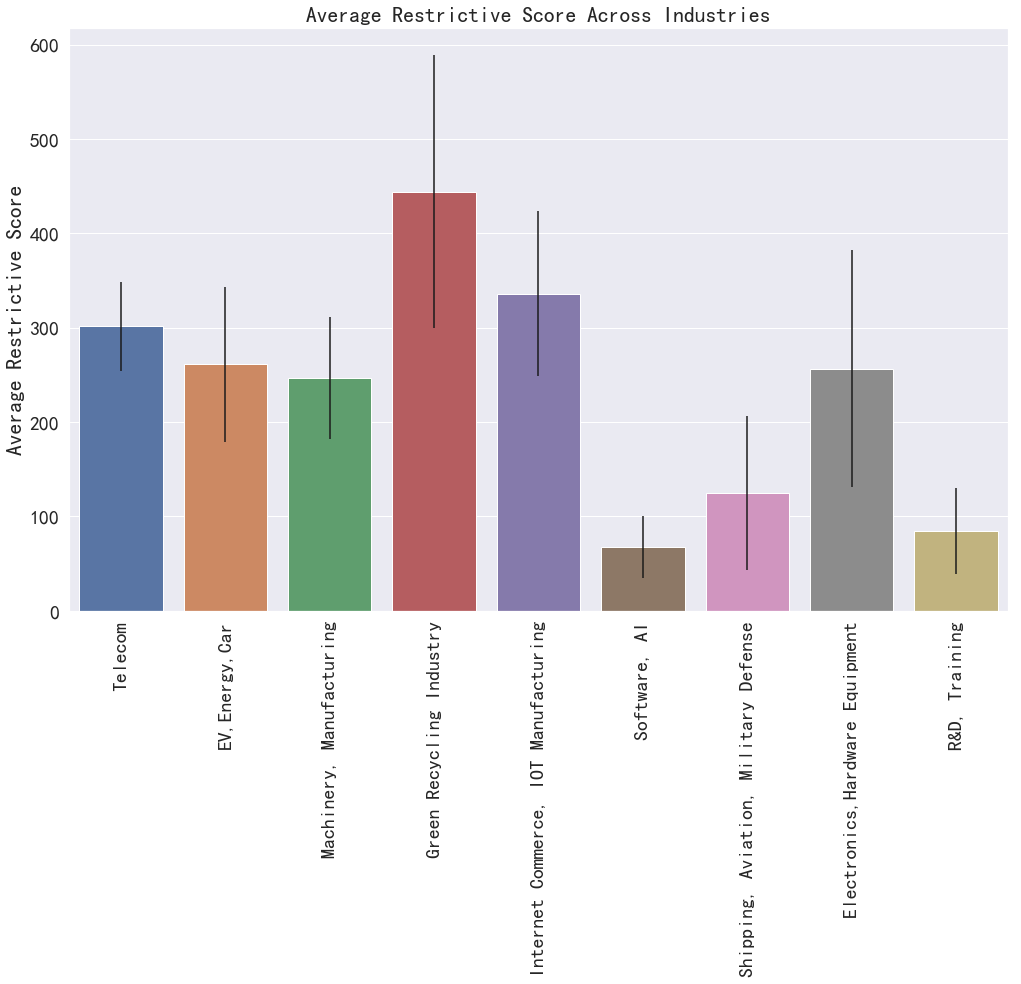

In [658]:
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]

district_dict = {}

#Assigns each test score series to a dictionary key
for district in industry:
    district_dict[district] = data[data['Ind_cat'] == district]['restrict_score']


y = []
yerror = []
#Assigns the mean score and 95% confidence limit to each district
for district in industry:
    y.append(district_dict[district].mean())
    yerror.append(1.96*district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    print(district + '_std : {}'.format(district_dict[district].std()))
sns.set(font_scale=1.8)
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

fig = plt.figure(figsize=(15,10))
ax = sns.barplot(industry, y, yerr=yerror)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_ylabel('Average Restrictive Score')
ax.set_title('Average Restrictive Score Across Industries')
plt.show()

Telecom_std : 2301.214817885312
EV,Energy,Car_std : 4313.56437350659
Machinery, Manufacturing_std : 7998.56184528495
Green Recycling Industry_std : 9075.201038924068
Internet Commerce, IOT Manufacturing_std : 5224.79900708378
Software, AI_std : 1859.5905218723683
Shipping, Aviation, Military Defense_std : 2048.1226632627904
Electronics,Hardware Equipment_std : 4080.9686809786404
R&D, Training_std : 664.8343360972896


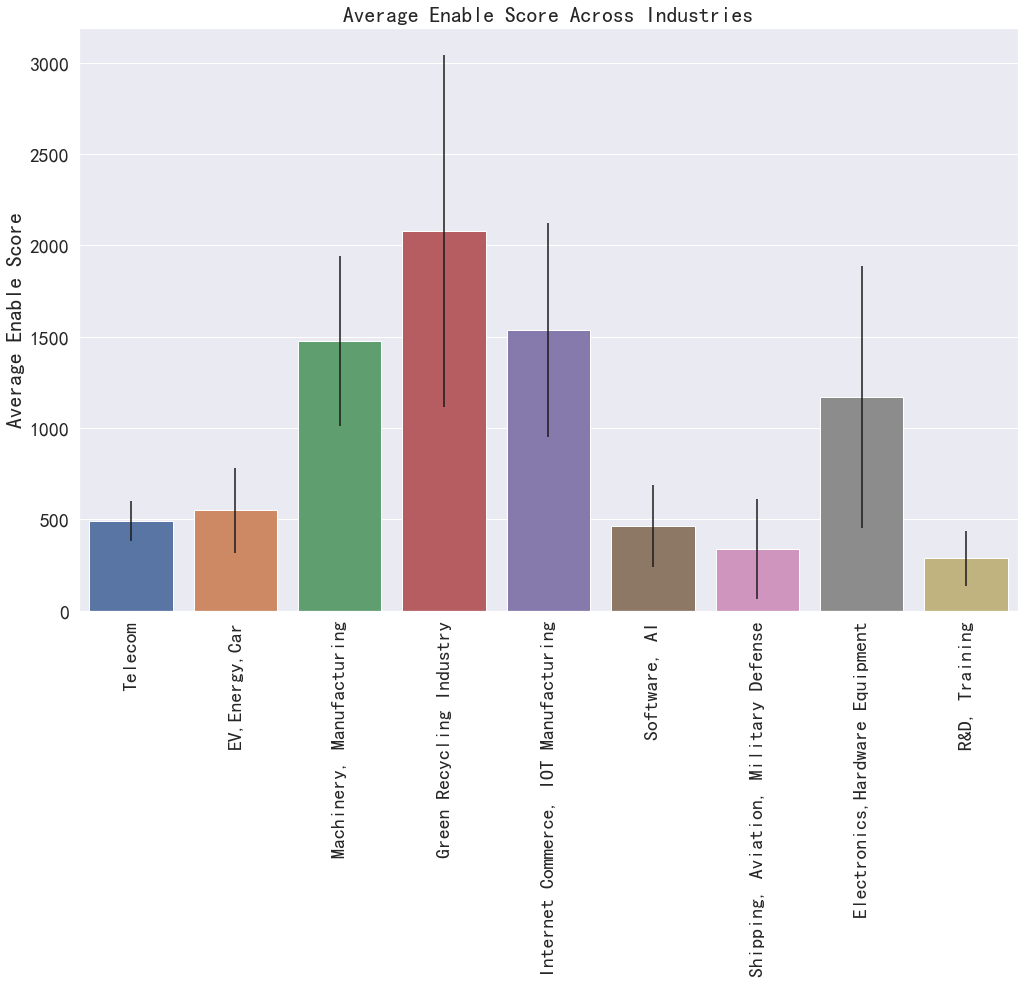

In [659]:
       
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]

district_dict = {}

#Assigns each test score series to a dictionary key
for district in industry:
    district_dict[district] = data[data['Ind_cat'] == district]['enable_score']


y = []
yerror = []
#Assigns the mean score and 95% confidence limit to each district
for district in industry:
    y.append(district_dict[district].mean())
    yerror.append(1.96*district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    print(district + '_std : {}'.format(district_dict[district].std()))
sns.set(font_scale=1.8)
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

fig = plt.figure(figsize=(15,10))
ax = sns.barplot(industry, y, yerr=yerror)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_ylabel('Average Enable Score')
ax.set_title('Average Enable Score Across Industries')
plt.show()

Telecom_std : 366471.0072674126
EV,Energy,Car_std : 1121732.5369145393
Machinery, Manufacturing_std : 1909396.8274753839
Green Recycling Industry_std : 1709391.5526757506
Internet Commerce, IOT Manufacturing_std : 688781.1658210007
Software, AI_std : 155346.41991441287
Shipping, Aviation, Military Defense_std : 304166.9919593239
Electronics,Hardware Equipment_std : 582700.9930184225
R&D, Training_std : 31229.10818463736


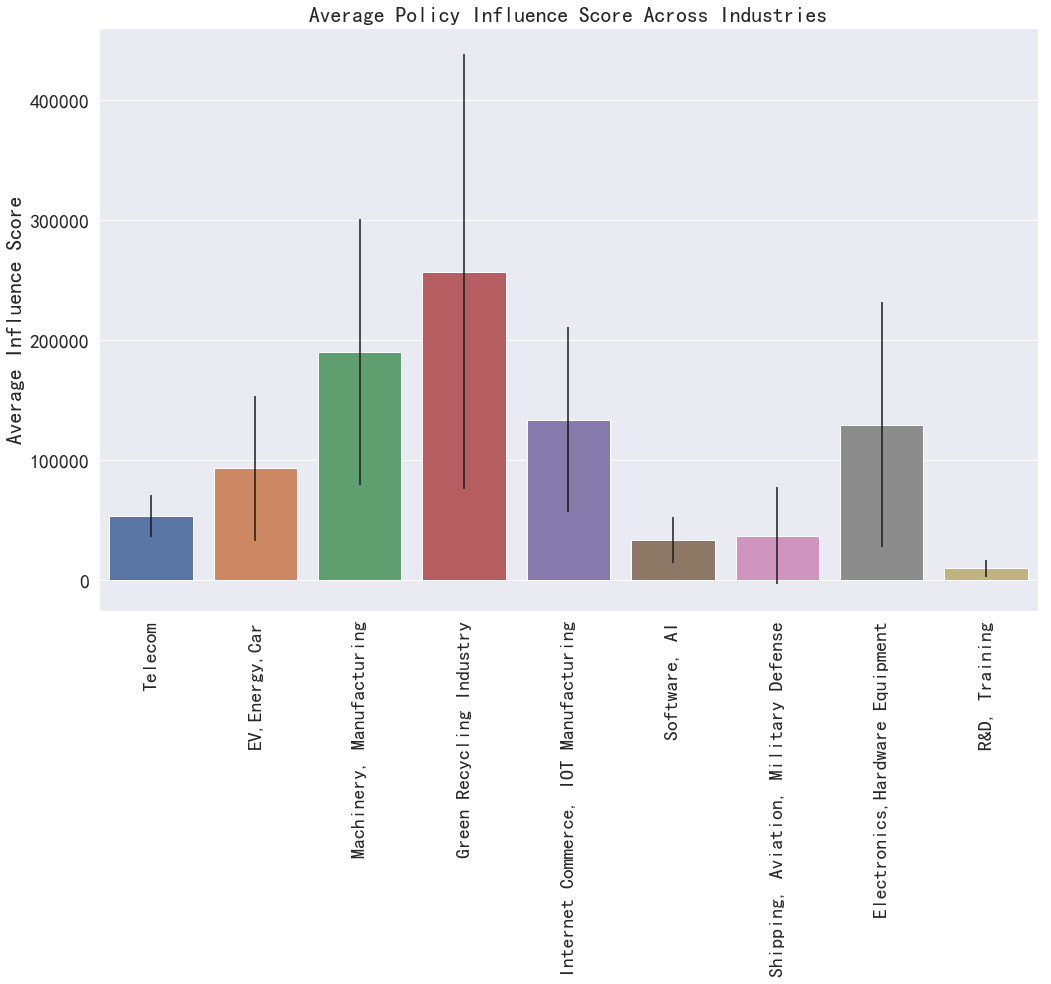

In [661]:
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]

district_dict = {}

#Assigns each test score series to a dictionary key
for district in industry:
    district_dict[district] = data[data['Ind_cat'] == district]['force']


y = []
yerror = []
#Assigns the mean score and 95% confidence limit to each district
for district in industry:
    y.append(district_dict[district].mean())
    yerror.append(1.96*district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    print(district + '_std : {}'.format(district_dict[district].std()))
sns.set(font_scale=1.8)
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

fig = plt.figure(figsize=(15,10))
ax = sns.barplot(industry, y, yerr=yerror)
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_ylabel('Average Influence Score')
ax.set_title('Average Policy Influence Score Across Industries')
plt.show()

In [721]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
stats.f_oneway(
    district_dict['Telecom'], district_dict['EV,Energy,Car'], \
    district_dict['Machinery, Manufacturing'], district_dict['Green Recycling Industry'], \
    district_dict['Internet Commerce, IOT Manufacturing'],district_dict['Software, AI'],\
    district_dict['Shipping, Aviation, Military Defense'],district_dict['Electronics,Hardware Equipment'],\
    district_dict['R&D, Training']
)

F_onewayResult(statistic=2.2970552942055606, pvalue=0.018711144947911547)

In [731]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('force ~ Ind_cat',
                data=data).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)



                sum_sq       df         F    PR(>F)
Ind_cat   7.379322e+13     10.0  1.258543  0.247932
Residual  6.849607e+16  11682.0       NaN       NaN


 [Document Count Validation](#Document-Count-Validation)

In [141]:
COUNTS_group = data.groupby(['DocType']).count().dimension_score.reset_index(drop=False)
COUNTS_group.sort_values('dimension_score', ascending=False).reset_index(drop=True)

,DocType,dimension_score
0,通知,3861
1,公告,2164
2,None,2125
3,意见,1096
4,函,671
5,通告,437
6,批复,242
7,决定,130
8,通报,110
9,报告,48


>> ### Observation:
- need to delete cases with 公报，命令，议案。because they only have one cases.

 ### Province

# NEWS SOURCES EXAMPLE

In [3]:
ind_scores = ['published_date','Ind_cat',
       'dimension_score',
       'restrict_score', 'enable_score', 'force']

data['published_date'] = pd.DatetimeIndex(data['published_date'])
data['year'] = pd.to_datetime(data['published_date']).dt.to_period('Y').astype(str)
#date_counts = data.groupby('year_month').count().date.reset_index(drop=True) # get the count of get the mass
data_year = data.groupby(['Ind_cat','year']).mean().reset_index(drop=False)
data_year = data_year[data_year.year != "2019"]
Counts = data.groupby(['Ind_cat','year']).count().reset_index(drop=False).id
data_year = pd.concat([data_year,Counts],axis = 1).reset_index(drop = True)
data_year.head()
data_year.columns = ['Ind_cat', 'year','Unnamed: 0', 'dimension_score', 'restrict_score', 'enable_score',
       'force', 'counts']
data_year.head()
#data_year['avg'] = (data_year.drop(['year_month'],axis=1).mean(axis=1)*data_year.date)/100

,Ind_cat,year,Unnamed: 0,dimension_score,restrict_score,enable_score,force,counts
0,"EV,Energy,Car",2008,5376.476190,9.000100,361.334776,1233.002457,133731.358267,21
1,"EV,Energy,Car",2009,6288.886525,6.120667,132.362783,233.285011,17455.247307,141
2,"EV,Energy,Car",2010,5009.228916,14.837449,229.971809,237.261274,35312.620190,166
3,"EV,Energy,Car",2011,5468.973913,9.034883,280.236197,199.410136,52012.679934,115
4,"EV,Energy,Car",2012,6293.210526,17.757995,704.918401,1026.518814,220163.662340,95


In [4]:
DATS =[]
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]

def trace(i):
    trace = dict(
        x= data_year[data_year['Ind_cat']==i].year,
        y= data_year[data_year['Ind_cat']==i].counts,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return trace
    
for i in industry:
    DATS.append(trace(i))
    
fig = go.Figure(data=DATS)
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Count of Policies',
            font=dict(
                #family='monospace',
                size=20,
                #color='#7f7f7f'
            )
        )
    ),
    autosize=True,
    margin=dict(
        autoexpand=True, 

    ),
    showlegend=True,
    plot_bgcolor='white',
    legend=dict(x=0,y=-0.25,
       orientation="h",
               font = dict(size =10))
#     legend=go.layout.Legend(
#         x=0,
#         y=200,
#         traceorder="normal",
#         font=dict(
#             family="sans-serif",
#             size=10,
#             #color="black"
#         )
# #         bgcolor="LightSteelBlue",
# #         bordercolor="Black",
#         #borderwidth=2
#     )
)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.3, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Number of Published Policy by Industry',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

annotations.append(dict(
  x = 2012,
  y = 230,
  text = '2012 - Xi Jinping takes Office',
  xref = "x",
  yref = "y"
))


fig.add_trace(go.Scatter(
    x=['2012','2012'],
    y=[0, 230],
    mode="lines+markers+text",
    hovertext=[" ","2012 - Xi Jinping takes Office"],
    textposition="top center",
    line=dict(color='black', width=0.5,dash= 'dot'),
    showlegend = False
    
))
fig.update_layout(annotations=annotations)

hide_toggle()

In [44]:
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]
plot_data = dict()
for j in range(0,len(DATS)):
    plot_data[DATS[j]['name']] = {
        DATS[j]['name']:{'x': DATS[j]['x'].tolist(), 'y':DATS[j]['y'].tolist()}}

In [39]:
plot_data = {
    DATS[0]['name']:{'x': DATS[0]['x'].tolist(), 'y':DATS[0]['y'].tolist()},
    DATS[1]['name']:{'x': DATS[1]['x'].tolist(), 'y':DATS[1]['y'].tolist()},
    DATS[2]['name']:{'x': DATS[2]['x'].tolist(), 'y':DATS[2]['y'].tolist()},
    DATS[3]['name']:{'x': DATS[3]['x'].tolist(), 'y':DATS[3]['y'].tolist()},
    DATS[4]['name']:{'x': DATS[4]['x'].tolist(), 'y':DATS[4]['y'].tolist()},
    DATS[5]['name']:{'x': DATS[5]['x'].tolist(), 'y':DATS[5]['y'].tolist()},
    DATS[6]['name']:{'x': DATS[6]['x'].tolist(), 'y':DATS[6]['y'].tolist()},
    DATS[7]['name']:{'x': DATS[7]['x'].tolist(), 'y':DATS[7]['y'].tolist()},
    DATS[8]['name']:{'x': DATS[8]['x'].tolist(), 'y':DATS[8]['y'].tolist()}, 
}



In [48]:
plot_data['EV,Energy,Car']['EV,Energy,Car']['x']

['2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

In [38]:
data = []
for i in range(0,len(industry)):
    for j in industry:
        data.append({'x': plot_data[i][j]['x'], 'y': plot_data[i][j]['y'],
                    'type': 'lines+markers+text', 'name': j, 'showlegend': 'True'})
data

KeyError: 'EV,Energy,Car'

In [34]:
plot_data[1]['EV,Energy,Car']['x']

['2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018']

In [32]:
plot_data

{0: {'Telecom': {'x': ['2003',
    '2004',
    '2005',
    '2006',
    '2007',
    '2008',
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018'],
   'y': [2, 4, 2, 5, 1, 42, 118, 228, 186, 153, 186, 203, 206, 167, 139, 71]}},
 1: {'EV,Energy,Car': {'x': ['2008',
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018'],
   'y': [21, 141, 166, 115, 95, 92, 107, 129, 137, 161, 133]}},
 2: {'Machinery, Manufacturing': {'x': ['2005',
    '2008',
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018'],
   'y': [2, 23, 58, 113, 51, 90, 53, 88, 172, 218, 199, 74]}},
 3: {'Green Recycling Industry': {'x': ['2008',
    '2009',
    '2010',
    '2011',
    '2012',
    '2013',
    '2014',
    '2015',
    '2016',
    '2017',
    '2018'],
   'y': [3, 5, 19, 16, 25, 33, 26, 49, 76, 66, 17]}},
 4: {'Internet Comm

In [5]:
# DAT = []
# for ind in industry:
#     DAT.append({'x': city_data[ind]['x'], 'y': city_data[city]['y'],
#                 'type': 'bar', 'name': city})
def update_graph(industry):
    dat = []
    for i in range(0,len(DATS)-1):                
        if DATS[i]['name'] == industry:
            dat.append(DATS[i])
    print(dat)
update_graph('EV,Energy,Car')

NameError: name 'DATS' is not defined

In [10]:
{DATS[0]['name']}
set(industry).intersection({DATS[0]['name']})

{'Telecom'}

In [19]:
industry = ['Telecom', 'EV,Energy,Car', 'Machinery, Manufacturing', 'Green Recycling Industry',            
'Internet Commerce, IOT Manufacturing' , 'Software, AI','Shipping, Aviation, Military Defense',   
'Electronics,Hardware Equipment', 'R&D, Training' ]

def trace(i):
    trace = dict(
        x= data_year[data_year['Ind_cat']==i].year,
        y= data_year[data_year['Ind_cat']==i].counts,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return trace

for i in industry:
    DATS.append(trace(i))

KeyError: 1

In [11]:
fig.show()

In [476]:
DATS =[]
industry = [ '汽车' , '制造业','专业服务','环境',
            '能源' , '化工', '教育','农业,渔业,林业,生物' ,
            '公共','石油','金融服务']

def trace(i):
    trace = dict(
        x= data_month[data_month['ind']==i].year,
        y= data_month[data_month['ind']==i].enable_score,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return trace
    
for i in industry:
    DATS.append(trace(i))
    
fig1 = go.Figure(data=DATS, layout=layout)
fig1.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(showgrid=True, zeroline=True, showline=True, showticklabels=True ),
    autosize=False,
    margin=dict(
        autoexpand=True, l=80,  r=20, t=60),
    showlegend=True,
    plot_bgcolor='white'
)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Industry Sector Enable Scores',
                              font=dict(family='Arial',
                                        size=35,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
fig1.update_layout(annotations=annotations)
fig1.show()

# Restrictive Trends
> ### the restrict score for Manufacturing,environmental protection have a general decreasing trend, implying the government is perhaps less restrictive in these markets. But overall, the restrictive scores for the major sectors are decreasing, insinuating perhaps there are either a change of regulation rhetoric or there are less regulations in these sectors. 
> ### Environment vs Manufacturing
- Interestingly enough, the average restrive scores of environmental protection and peaked at 2009 and 2013, while the manufacturing restrictive scores reached local minimum during those two years, implying there are perhaps a negative relationship between policy restrictiness between environment protection and manufacturing related policies. Data cannot provide any cause effect explains to this pattern, however the government seems to have opposing restrictive measures for these two areas. 
> ### Manufacturing vs Energy.
- Another interesting finding is that manufacturing restrictive scores are correlated with the energy restrictive scores from 2009 up to date, as both industry sectors reached a local maximum peak in 2011. This data suggests perhaps implies the government may have similar market access planning and cataloging for energy and manufacturing sectors. 
> ### Chemcial vs. Safety.
- restrictiv score for chemcial and safety standards are increasing over the years, implaying the government is tightening the regulations. 
> ### Safety Standards vs Professional Services 
- they have opposite relationships, as one increase, the other decreases, implying that the government try to decrease regulation on professional services while increase regulation on safty standards.
> ### Safety Standards vs Environmental Sectors
- both are somewhat correlated, meaning as safety standards tightens, the Environmental sectors also tightens.
> ### Public Goods vs Energy Sectors
- both are somewhat correlated, perhaps even auto-correlated with public-goods restrictive score laggin behind, meaning as energy sectors restrictive score rises, public-goods restrictiveness score also rises, perhaps by cause and effect.


In [386]:
fig.show()

# Enable Trends
> ### Automotive vs Energy sector vs Chemical Industry.
- Another interesting finding is that Automotive and Energy sectors's enability are correlated, as government guidance and support for automotive industry rises, the energy sector's guidance also rises. This data suggests perhaps implies the government may have similar manner in guiding, planning and cataloging for energy and automotive sectors.
> ### Environment vs Energy industry:
- the push and guidance for both are obvious related as they go hand-in-hand with the development progress. The gov is attempting to increase the push for energy efficiency while pushing for environmental protection. 

> ### Environment vs Manufacturing Industry:
- both are correlated, perhaps implies the way gov guidance allocate resources for environmental sectors are similar to that of the manufacturing. This is logical because environmental sector is a related to manufacturing industry.

> ### Environment vs Public Goods:
- the push and guidance for both are obvious related as they go hand-in-hand with the development of China's image of a clean and healthy environment as a public good that all citizen should enjoy. The gov is attempting to increase the resource allocation for environmental cleanup through perhaps supporting public state-owned enterprises. 

> ### Public goods vs Manufacturing Industry:
- both are surprisingly correlated, perhaps just a behavioral pattern that are not related at all, implies the way gov guidance allocate resources for both sectors are similar just by mere chance. 

> ### Professional Services vs Public goods:
- both seem to behave in opposite ways in terms of enable scores and governemnt support, as the gov increases the support for professional services, the support for public goods decreases. This perhaps is giving insights to restructuring and reforming of the socialist market economy, as the government contribute more attention to the private enterprises, the less resources to allocate to support the public goods or SOEs.

## Examining Individual industries: Enabling vs Restrictive scores implies opposite effects
> Financial Services: 
- 2012 reached global maximum in restrictive score, but reach all time low on enabling score, implying government in 2012 planned to tighten up banking and financial regulations and less on guiding and enabling.
- 2016 restrictive score is all time minimum while enable score reached a global maximum, implying government is reversing the plan in 2012 to boost and increase policies to guide the financial services sector. (google what happened in 2012 and 2016 in financial services)
> Environmental Protection sector:
- also is similar relationship: 2009 reached global maximum on restrictive score while enabling score was relatively low. However from 2009 to 2018, when the restrictive-score decreased overall decrease of 85%, the enable-score increase about 20%. Please see the Figure(z) to understand the trend. 
> Energy Industry:
- During the period of 2011 to 2019, the restrictive-score decreased 77%, while the enabling-score increased about 33%. This again can be interpreted as the governments change of policy rhetoric from restricting (managing) the Energy sector to guiding (enabling) the Energy sector.  
> Agriculture, Fishing, Forestry:
- As the restrictive score increase, the Enable score also increases, direct correlation. both have all time global max in 2013, data suggests the government plan to utilize both enabling and restricting economic set of tools for this industry. 
> Automotive Industry:
- During the period of 2009 to 2017, data displays high restritive scores in 2009, 2010, 2012, but reflected low enabling scores during those years. As oppose to 2017, there was a huge spike in Enabling score increased from 2009 by 92%, and a decrease in restrictive score by 43%. 
# take-away: the gov uses different economic instrument tactics for different industries. (refer to the framework box)

# Digital Channel of Distribution

In [394]:
data.id.value_counts()/len(data)

MIITmiit_policy_ver2         0.339179
MIITmiit_policy_release      0.327117
MIITdocument_opinions        0.241061
MIITfeedback_proposal        0.031822
MIITmiit_policy_explained    0.025577
MIITinvestment_plans         0.025321
MIITlaw_regulation_dept      0.008298
MIITfinancial_resources      0.001625
Name: id, dtype: float64

- The bulk of policy documents are distributed through the digital webpages through ***Policy Publication Page*** (policy_ver2_政策发布), ***Document Opinions Page*** (document_opinion_意见), ***Document Release page*** (policy_release_文件发布), which make up 93% of the procured data sample from MIIT, used in this analysis. The rest of the 7% are distributed over ***feedback_proposal***, policy_explained, investment_plans, law_regulation_dept,financial_resources. The hypothsis is that the distribution channels online or offline can uncover insights to answer question 3: how does the government organize to optimize the planning and implementation of the industrial policies? 

In [16]:
data = pd.read_csv(r'C:\Users\ASUS\Desktop\Thesis\newMIIT_analysis.csv')

In [19]:
data_qtr.head()

,id,year,Unnamed: 0,dimension_score,restrict_score,enable_score,force,enable_score
0,MIITdocument_opinions,2008,2795.5,10.659191,255.842620,62.364975,21249.593982,44
1,MIITdocument_opinions,2009,2673.5,5.065100,55.690787,63.985765,5108.635494,200
2,MIITdocument_opinions,2010,2355.0,23.329619,353.469709,354.778709,91404.497596,437
3,MIITdocument_opinions,2011,2019.5,9.132579,48.949880,31.966951,7633.192147,234
4,MIITdocument_opinions,2012,1802.0,3.104578,17.423391,16.701982,1329.971153,201


In [20]:
data['published_date'] = pd.DatetimeIndex(data['published_date'])
data['year'] = pd.to_datetime(data['published_date']).dt.to_period('Y').astype(str)
#date_counts = data.groupby('year_month').count().date.reset_index(drop=True) # get the count of get the mass
data_qtr = data.groupby(['id','year']).mean().reset_index(drop=False)
#data_qtr = data_month[data_month.year != "2019"]
Counts = data.groupby(['id','year']).count().reset_index(drop=False).enable_score
data_qtr = pd.concat([data_qtr,Counts],axis = 1).reset_index(drop = True)
data_qtr.columns = ['id', 'year','Unnamed: 0', 'dimension_score', 'restrict_score', 'enable_score',
       'force', 'counts']
data_qtr.head()


,id,year,Unnamed: 0,dimension_score,restrict_score,enable_score,force,counts
0,MIITdocument_opinions,2008,2795.5,10.659191,255.842620,62.364975,21249.593982,44
1,MIITdocument_opinions,2009,2673.5,5.065100,55.690787,63.985765,5108.635494,200
2,MIITdocument_opinions,2010,2355.0,23.329619,353.469709,354.778709,91404.497596,437
3,MIITdocument_opinions,2011,2019.5,9.132579,48.949880,31.966951,7633.192147,234
4,MIITdocument_opinions,2012,1802.0,3.104578,17.423391,16.701982,1329.971153,201


In [760]:
pages = ["MIITmiit_policy_ver2"   ,
"MIITmiit_policy_release"      ,
"MIITdocument_opinions"        ,
"MIITfeedback_proposal"        ,
"MIITmiit_policy_explained"    ,
"MIITinvestment_plans"       ,
"MIITlaw_regulation_dept"   ,
"MIITfinancial_resources" ]

def trace(i):
    count = dict(
        x= data_qtr[data_qtr['id']==i].year,
        y= data_qtr[data_qtr['id']==i].counts,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return count

def trace_enable(i):
    enable = dict(
        x= data_qtr[data_qtr['id']==i].year,
        y= data_qtr[data_qtr['id']==i].enable_score,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return enable

def trace_restrict(i):
    restrict = dict(
        x= data_qtr[data_qtr['id']==i].year,
        y= data_qtr[data_qtr['id']==i].restrict_score,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return restrict

DATS =[]
for i in industr:
    DATS.append(trace(i))

enabs = []
for i in pages:
    enabs.append(trace_enable(i))
restr = []
for i in pages:
    restr.append(trace_restrict(i))
    
fig1 = go.Figure(data=DATS, layout=layout)
fig1.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
   
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Count of Policies',
            font=dict(
                #family='monospace',
                size=20,
                #color='#7f7f7f'
            )
        )
    ),
    autosize=True,
    margin=dict(
        autoexpand=True, 

    ),
    showlegend=True,
    plot_bgcolor='white',
    legend=dict(x=0,y=-0.25,
       orientation="h",
               font = dict(size =10))
)
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.1, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Count of Policies per Webpage Channel',
                              font=dict(family='Arial',
                                        size=35,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
annotations.append(dict(
  x = 2010,
  y = 437,
  text = '1',
  xref = "x",
  yref = "y"
))

annotations.append(dict(
  x = 2012,
  y = 458,
  text = '2',
  xref = "x",
  yref = "y"
))

annotations.append(dict(
  x = 2013,
  y = 426,
  text = '3',
  xref = "x",
  yref = "y"
))

annotations.append(dict(
  x = 2015,
  y = 532,
  text = '4',
  xref = "x",
  yref = "y"
))
fig1.update_layout(annotations=annotations)


############################################
fig2 = go.Figure(data=enabs, layout=layout)
fig2.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(showgrid=True, zeroline=True, showline=True, showticklabels=True ),
    autosize=False,
    margin=dict(
        autoexpand=True, l=80,  r=20, t=60),
    showlegend=True,
    plot_bgcolor='white'
)

annotations2 = []
annotations2.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Enability of Webpage Channel',
                              font=dict(family='Arial',
                                        size=35,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations2.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
fig2.update_layout(annotations=annotations2)

#############################

fig3 = go.Figure(data=restr, layout=layout)
fig3.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(showgrid=True, zeroline=True, showline=True, showticklabels=True ),
    autosize=False,
    margin=dict(
        autoexpand=True, l=80,  r=20, t=60),
    showlegend=True,
    plot_bgcolor='white'
)

annotations3 = []
annotations3.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Restrictiveness of Webpage Channel',
                              font=dict(family='Arial',
                                        size=35,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations3.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
fig3.update_layout(annotations=annotations3)
#################################

fig1.add_trace(go.Scatter(
    x=['2015','2015'],
    y=[0, 532],
    mode="lines+markers+text",
    hovertext=[" ","2015: Made in China 2025, China Internet Plus Initiative, Supply-side Structural Reform"],
    textposition="top center",
    line=dict(color='black', width=0.5, dash= 'dot'),
    showlegend = False
))

fig1.add_trace(go.Scatter(
    x=['2013','2013'],
    y=[0, 426],
    mode="lines+markers+text",
    hovertext=[" ","2013: Renew Reform Programs: revisiting market reforms"],
    textposition="top center",
    line=dict(color='black', width=0.5,dash= 'dot'),
    showlegend = False
))

fig1.add_trace(go.Scatter(
    x=['2012','2012'],
    y=[0, 458],
    mode="lines+markers+text",
    hovertext=[" ","2012: State Council 12th Five Year Plan (FYP) on Development of Strategic Emerging Industries (SEI); NDRC Issued Funds Allocation Guiding Catalogue for Strategic Emerging Industries, MIIT Classification Catalogue"],
    textposition="top center",
    line=dict(color='black', width=0.5, dash= 'dot'), #"solid", "dot", "dash", "longdash", "dashdot", or "longdashdot"
    showlegend = False
))

fig1.add_trace(go.Scatter(
    x=['2010','2010'],
    y=[0, 437],
    mode="lines+markers+text",
    hovertext=[" ","2010: MIIT approved five electronic industry standards, Accelerating cultivation and development of strategic emerging industries (SEI)"],
    textposition="top center",
    line=dict(color='black', width=0.5,dash= 'dot'),
    showlegend = False
    
))




#fig1.update_layout(annotations=annotations)
hide_toggle()

# Document Count Validation

In [761]:
fig1.show()

- the overall count of documents published in each channel reciprocates quite well with the true events occured in 2010, 2012, 2013, 2015. 

In [452]:
fig2.show()

# Enable Channels
- The top three digital webpages that appears to reflect the most "enabling" rhetoric are: Policy Explained section, policy publication, and financial resources section. Data suggests that the policy_explained section (政策解读) contains the most enabling characteristics. Because these documents have the purpose of encouraging enterprises and local governaments to implement new regulations, they naturally have some political and encouraging rhetoric. 

In [455]:
fig3.show()

# Restricting Channels
- Data suggests that Policy Publication Channel's restrictive score is average increasing after 2012, suggesting perhaps this webpage tend to be associated with market tightening and regulatory rhetoric.
- from 2015 to 2018, the restrivtive rhetoric of the feedback proposal channels has the highest growth of "restrictive score" (grew by 300%), implying perhaps the government feedback on market proposals are more stringent and regulated than before.
- from 2011 to 2018, the restrictive rhetoric of the Financial Resources Web Channel also increasing about 300%, implying perhaps the subsidies and funding of the government is tightening up. This data can also be interpreted as a increasing intensity in financial management of the strategic emerging industries projects. This observation coexists with the rising Enableness within the Financial Resource channel. A reasonable conclusion would be MIIT is both increasing the intensity of enabling-guiding, at the same time restricting the enterprises what they can or cannot do. 

# individual Channels comparison:
- from 2010 to 2018, Data shows tha the Document Release channel has a decreasing Restrictive Control rhetoric (~45%) while increasing in the "enable score" of Leading, guiding the industries by about 15.3%. Because this channel displays higher "enable score" over time, there is a possibility the governement is utilizing this channel to announce positive developments, subsidies and other 'enabling economic tools.'
- 意见 Document opinions asks for the public or the market's feedback opinion on new policies and has a specific window for expressing opinion. from 2011 to 2018, it has also decreased its restrictive tone and clearly increased its "enable score" by about 20%. 
- Feedback proposal: has a direct opposite effect with its "enable score" and "restricing score", as seen in 2016 to 2018, there is a direct increase in restrictiveness and decrease of "enabling" rhetoric.
- Investment Plans channel & Financial resources Channel: seems to have correlated Restrict Score and Enable Score. This could imply the finacnial and investment planning are neutral of either measures of Restrictiveness and Enability. 

In [461]:
# PROVINCE! how to relate visually Province & Ind & channels ??

Index(['id', 'published_date', 'link', 'title', 'DocType', 'DocType2',
       'DocType3', 'pi_no', 'hao_no', 'Prov', 'Prov1', 'Prov2', 'Prov3', 'ind',
       'ind1', 'ind2', 'ind3', 'Manufkt', 'Dept', 'Dept1', 'dimension_score',
       'restrict_score', 'enable_score', 'force', 'label', 'year', 'Q'],
      dtype='object')

In [472]:
#date_counts = data.groupby('year_month').count().date.reset_index(drop=True) # get the count of get the mass
data_qtr = data.groupby(['DocType','year']).mean().reset_index(drop=False)
#data_qtr = data_month[data_month.year != "2019"]
Counts = data.groupby(['DocType','year']).count().reset_index(drop=False).enable_score
data_qtr = pd.concat([data_qtr,Counts],axis = 1).reset_index(drop = True)
data_qtr.columns = ['DocType', 'year', 'dimension_score', 'restrict_score', 'enable_score',
       'force', 'label', 'counts']
data_qtr.head()

,DocType,year,dimension_score,restrict_score,enable_score,force,label,counts
0,None,2002,3.000000,13.000000,1.0,42.000000,1.0,2
1,None,2003,2.000000,34.000000,2.0,72.000000,1.0,2
2,None,2005,7.333333,50.333333,2.0,403.333333,1.0,3
3,None,2006,7.400000,14.800000,4.0,314.700000,0.7,10
4,None,2007,100.000000,16.000000,5.0,2100.000000,1.0,1


In [471]:
data_qtr.DocType.value_counts()

None    17
通知      15
报告      13
意见      13
通告      12
公告      12
函       12
通报      11
决定      11
批复      10
Name: DocType, dtype: int64

In [473]:
docTypes = ['通知' ,'报告','意见','通告','公告','函','通报','决定','批复']
DATS = []
def trace(i):
    trace = dict(
        x= data_qtr[data_qtr['DocType']==i].year,
        y= data_qtr[data_qtr['DocType']==i].counts,
        name=i,
        hoverinfo='x+y+name',
        mode='lines',
        line=dict(width=3))
    return trace
    
for i in docTypes:
    DATS.append(trace(i))
    
fig = go.Figure(data=DATS, layout=layout)
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        #text='Enable Score',
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        autoexpand=False, 
        l=80,
        r=200,
        t=60,
    ),
    showlegend=True,
    plot_bgcolor='white'
)

annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Count of Documents by Type',
                              font=dict(family='Arial',
                                        size=20,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: MIIT public policy',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

In [2]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [3]:
data = data[data['id']!='MIITmiit_policy_release'].reset_index(drop=True)
data['id'] = data.id.replace({
    'MIITmiit_policy_ver2': 'Policy Publication (文件发布)',
    'MIITdocument_opinions': 'Document Release (文件公示,意见)',
    'MIITmiit_policy_explained': 'Policy Explained (政策解读)',
    'MIITfeedback_proposal': 'Document Feedback (建议提案复文公开)',
    'MIITinvestment_plans': 'Investment Plans (规划投资计划)',
    'MIITlaw_regulation_dept': 'Laws & Regulations (法律法规)',
    'MIITfinancial_resources':'Financial Resources (财政资金)'
})

In [4]:
data['Raw_mat_cat'] = data.Raw_materials.replace({
    '农药':'Pesticides',         
    '水泥':'Cement',        
    '冶金':'Metal Materials',          
    '石化':'Petrochemical',          
    '包装':'Packaging',          
    '钢铁':'Steel',           
    '炸药':'Explosives Materials',      
    '铁合金':'Iron Materials',       
    '建材':'Building Materials',       
    '印染':'Printing & Dye',        
    '化学品':'Chemicals',       
    '萤石':'Fluorite',        
    '石油':'Oil',            
    '废钢铁':'Scrap Metal',
    '铜冶炼':'Copper',
    '轮胎翻新':'Tires Reuse',
    '玻璃纤维':'Glass Fiber',
    '铸造用生铁':"Iron Materials",
    '化学':'Chemicals',
    '建筑卫生陶瓷':'Ceramics',
    '三聚氰胺':'Melamine',
    '轨道资源':'Railroad Materials',
    '冶金, 包装':'Metal Materials',
    '铁合金, 铁合金':'Iron Materials'
    
    
})
# OTHERS revalue
a = data.Raw_mat_cat.value_counts()
a = a[a < 4].index
data.Raw_mat_cat = data.Raw_mat_cat.replace({x:'other materials' for x in a})
data.Raw_mat_cat.value_counts()

None                    6332
Pesticides               979
Cement                    72
Metal Materials           58
Petrochemical             48
Packaging                 45
other materials           41
Iron Materials            37
Steel                     35
Explosives Materials      34
Chemicals                 30
Building Materials        26
Printing & Dye            24
Fluorite                  20
Oil                       20
Scrap Metal               18
Copper                    14
Tires Reuse               12
Glass Fiber               11
Ceramics                   5
Railroad Materials         4
Melamine                   4
Name: Raw_mat_cat, dtype: int64

In [10]:
data.tail()

,Unnamed: 0,id,published_date,link,title,body,DocType,SubDocType,Type_industry,Prov,...,Supp_manip,Dem_manip,DimType,dimension_score,restrict_score,enable_score,force,Dim_cat,Ind_cat,Raw_mat_cat
7864,11688,Investment Plans (规划投资计划),2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展目标,1、“十一五”发展目标\r\r\n初步建立以企业为主体，市场为导向，应用为主线，“政产学研资...,None,None,软件,None,...,None,None,"规划, 规划, 目标",9.0001,9.0010,90.0019,8.910360e+02,planning,"Software, AI",None
7865,11689,Investment Plans (规划投资计划),2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展思路,我国信息产业科技发展的总体思路是“一体双翼”，即围绕一个战略主体，选择两大发展方向，逐步实现...,None,None,None,None,...,None,None,"规划, 规划, 发展思路",8.0001,8.0009,168.0029,1.408048e+03,planning,None,None
7866,11690,Investment Plans (规划投资计划),2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——指导思想,我国信息产业的科技发展要以邓小平理论和“三个代表”重要思想为指导，以科学发展观统领全局，紧密...,None,None,None,None,...,None,None,"规划, 规划",9.0001,18.0011,306.0043,2.916081e+03,planning,None,None
7867,11691,Investment Plans (规划投资计划),2006-08-04,http://www.miit.gov.cn/n1146295/n1146562/n1146...,《信息产业科技发展“十一五”规划和2020年中长期规划纲要》——发展重点,根据信息产业技术发展趋势、战略需求和发展思路，提出未来5～15年以下15个领域发展的重点技术...,None,None,通信,None,...,None,None,"规划, 规划",13.0001,78.0019,117.0022,2.535073e+03,planning,Telecom,None
7868,11692,Investment Plans (规划投资计划),2006-05-08,http://www.miit.gov.cn/n1146295/n1146562/n1146...,2006━2020年国家信息化发展战略,中办发〔2006〕11号\r\r\n信息化是当今世界发展的大趋势，是推动经济社会变革的重要力...,None,None,None,None,...,None,国际市场,规划,73.0001,3577.0122,30368.0489,2.477993e+06,planning,None,None


### SUBTSET data into Strategic Sector: 5G, New EV, Robotics

In [9]:
PLENUM1 = data[data['title'].str.contains('5G')==True].reset_index(drop=True)
PLENUM2 = data[data['title'].str.contains('移动信息')==True].reset_index(drop=True)
MOBILE = pd.concat([PLENUM1,PLENUM2],axis = 0).reset_index(drop=True)
PLENUM2.tail()

,Unnamed: 0,id,published_date,link,title,body,DocType,SubDocType,Type_industry,Prov,...,Supp_manip,Dem_manip,DimType,dimension_score,restrict_score,enable_score,force,Dim_cat,Ind_cat,Raw_mat_cat


In [40]:
SANKY =  data.groupby(['Dim_cat','DocType','Ind_cat']).count().reset_index(drop=False)
SANKY = SANKY.drop(columns=[ 'id', 'published_date',
       'link', 'title', 'body', 'SubDocType', 'Type_industry', 'Prov', 'Pi_no',
       'Hao_no', 'Dept', 'Audience', 'Raw_materials', 'Tax', 'Price_manip',
       'Supp_manip', 'Dem_manip', 'DimType', 'dimension_score',
       'restrict_score', 'enable_score', 'force', 'year', 'Raw_mat_cat'])
SANKY.columns = ['Dim_cat', 'DocType', 'Ind_cat', 'count']
SANKY = SANKY[SANKY['Dim_cat']!='None'].reset_index(drop=True)
SANKY = SANKY[SANKY['DocType']!='None'].reset_index(drop=True)
SANKY = SANKY[SANKY['Ind_cat']!='None'].reset_index(drop=True)
SANKY.head()

,Dim_cat,DocType,Ind_cat,count
0,favoring,Announcement,"EV,Energy,Car",2
1,favoring,Letters,"Shipping, Aviation, Military Defense",2
2,favoring,Message,"EV,Energy,Car",2
3,favoring,Message,"Electronics,Hardware Equipment",2
4,favoring,Message,Green Recycling Industry,2


In [41]:
import plotly
import chart_studio.plotly as py

fig = genSankey(SANKY,cat_cols=['Dim_cat','DocType','Ind_cat'],value_cols='count',title='Raw Materials Association Channels from MIIT Policies')
plotly.offline.plot(fig, validate=False)

KeyError: 'Raw_mat_cat'